In [2]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
#from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

from structured import *
import seaborn as sns

# Data

In [3]:
covid_df = pd.read_csv("covid_data.csv")
covid_df.drop(['Unnamed: 0', 'Patient ID'], axis=1, inplace=True)

covid_cols = ["SARSCov", "Hemoglobin", "Platelets", "Leukocytes",
                     "Lymphocytes", "Basophils", "Eosinophils", "Neutrophils",
                     "Monocytes", "Patient age quantile", "Urea", "Proteina C reativa mg/dL",
                     "Creatinine", "Potassium", "Sodium", "Alanine transaminase",
                     "Aspartate transaminase", "International normalized ratio (INR)",
                     "Albumin"]

# covid_df = covid_df[covid_cols]

In [122]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [123]:
covid_df

,Patient age quantile,SARSCov,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,1,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Patient age quantile', ylabel='Count'>

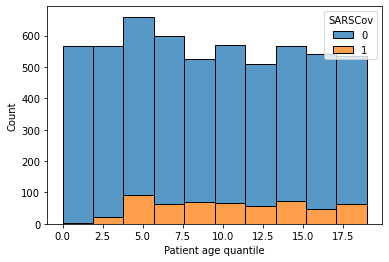

In [194]:
sns.histplot(data=covid_df, x='Patient age quantile',  bins=10, hue='SARSCov', multiple="stack") #hue='SARSCov'

In [124]:
covid_df.shape

(5644, 110)

In [125]:
display_all(covid_df.isna().sum())

Patient age quantile                                        0
SARSCov                                                     0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
Patient addmited to intensive care unit (1=yes, 0=no)       0
Hematocrit                                               5041
Hemoglobin                                               5041
Platelets                                                5042
Mean platelet volume                                     5045
Red blood Cells                                          5042
Lymphocytes                                              5042
Mean corpuscular hemoglobin concentration (MCHC)         5042
Leukocytes                                               5042
Basophils                                                5042
Mean corpuscular hemoglobin (MCH)                        5042
Eosinophils                                              5042
Mean cor

In [126]:
df = covid_df[covid_df['Hemoglobin'].notna()]

In [127]:
df.shape

(603, 110)

In [128]:
df.shape[0]-236

367

In [129]:
df = df.dropna(thresh=367, axis=1) # thresh - require that many non-NA values

In [130]:
df.SARSCov.value_counts()

0    520
1     83
Name: SARSCov, dtype: int64

In [131]:
df.dtypes.value_counts()

float64    20
int64       5
dtype: int64

In [132]:
df.select_dtypes(['int64']).isna().sum()

Patient age quantile                                     0
SARSCov                                                  0
Patient addmited to regular ward (1=yes, 0=no)           0
Patient addmited to semi-intensive unit (1=yes, 0=no)    0
Patient addmited to intensive care unit (1=yes, 0=no)    0
dtype: int64

In [133]:
display_all(df.select_dtypes(['float64']).isna().sum())

Hematocrit                                            0
Hemoglobin                                            0
Platelets                                             1
Mean platelet volume                                  4
Red blood Cells                                       1
Lymphocytes                                           1
Mean corpuscular hemoglobin concentration (MCHC)      1
Leukocytes                                            1
Basophils                                             1
Mean corpuscular hemoglobin (MCH)                     1
Eosinophils                                           1
Mean corpuscular volume (MCV)                         1
Monocytes                                             2
Red blood cell distribution width (RDW)               1
Neutrophils                                          90
Urea                                                207
Proteina C reativa mg/dL                            101
Creatinine                                      

<AxesSubplot:xlabel='Patient age quantile', ylabel='Count'>

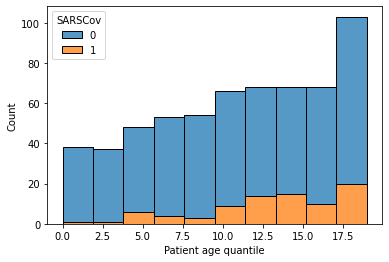

In [196]:
sns.histplot(data=df, x='Patient age quantile', bins=10, hue='SARSCov', multiple="stack")

In [244]:
X = df.drop(df.columns[[1,2,3,4]], axis=1).copy()
y = df.SARSCov.copy()

In [245]:
X

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
1,17,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,...,1.482158,0.166192,0.357547,-0.625073,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512
8,1,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,-0.223767,...,1.018625,-1.336024,0.068652,-0.978899,-0.127395,-0.067309,-0.286986,-1.838623,0.930020,0.503132
15,9,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,0.081693,...,-0.666950,1.668409,1.276759,-1.067355,0.880570,-0.811643,NaN,-0.908177,0.435697,-0.215628
18,11,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,-0.834685,...,-0.709090,0.606842,-0.220244,0.171035,0.265957,NaN,-0.487674,NaN,NaN,NaN
22,9,0.190738,-0.147652,-0.668155,1.020415,-0.127191,0.002791,-1.249524,-1.132592,0.387152,...,-0.709090,0.566783,2.012129,0.613318,-0.422410,-1.332677,NaN,-0.908177,-0.552949,-0.575008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,19,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,-0.834685,...,0.892207,-0.474754,1.066653,0.347948,1.118221,0.379292,3.627427,0.470262,0.188535,-5.246946
5614,19,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,0.081693,...,-0.540532,-1.976971,1.670707,0.967144,1.134611,-0.067309,5.733660,0.504723,-0.552949,-0.215628
5615,15,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,-0.223767,...,-0.709090,0.005955,0.909074,-1.155812,-0.061837,-0.365042,0.561468,-0.494645,0.435697,0.143752
5618,17,-3.242548,-2.779203,-1.773594,-0.550290,-3.318285,-1.830953,1.538664,-1.733675,-1.140144,...,-0.582671,1.408024,1.381812,-0.448160,1.552548,2.240127,0.609157,0.470262,-0.305787,-1.293767


In [246]:
X.describe()

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
count,603.000000,6.030000e+02,6.030000e+02,6.020000e+02,5.990000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,...,6.020000e+02,6.020000e+02,6.010000e+02,6.020000e+02,5.130000e+02,396.000000,502.000000,423.000000,370.000000,368.000000
mean,11.140962,-2.186214e-09,-1.601319e-08,-3.535003e-10,7.438143e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,...,7.206147e-09,-4.155370e-09,-3.220114e-09,1.020433e-08,5.908361e-09,0.000922,0.003367,0.004102,-0.001846,0.001172
std,5.718045,1.000830e+00,1.000830e+00,1.000832e+00,1.000836e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,...,1.000832e+00,1.000832e+00,1.000833e+00,1.000832e+00,1.000976e+00,1.002360,1.004205,0.998793,1.002074,1.000792
min,0.000000,-4.501420e+00,-4.345603e+00,-2.552426e+00,-2.457575e+00,-3.970608e+00,-1.865070e+00,-5.431808e+00,-2.020303e+00,-1.140144e+00,...,-8.355077e-01,-5.101581e+00,-2.163721e+00,-1.598094e+00,-3.339775e+00,-1.630410,-0.535362,-2.389999,-2.283079,-5.246946
25%,7.000000,-5.188074e-01,-5.862439e-01,-6.053457e-01,-6.624832e-01,-5.679496e-01,-7.307069e-01,-5.524761e-01,-6.372547e-01,-5.292256e-01,...,-6.669502e-01,-5.148128e-01,-6.141920e-01,-6.250727e-01,-6.518655e-01,-0.588343,-0.514995,-0.632489,-0.800110,-0.575008
50%,12.000000,5.340703e-02,4.031596e-02,-1.217160e-01,-1.015171e-01,1.385207e-02,-1.426696e-02,-5.458523e-02,-2.128790e-01,-2.237665e-01,...,-3.298351e-01,6.604462e-02,-1.151911e-01,-1.827903e-01,-5.364196e-02,-0.141742,-0.393291,-0.081113,-0.058626,0.143752
75%,16.000000,7.171751e-01,7.295320e-01,5.314981e-01,6.838353e-01,6.661759e-01,5.976919e-01,6.424628e-01,4.542955e-01,3.871516e-01,...,3.443949e-01,6.268712e-01,4.888627e-01,3.479481e-01,6.838943e-01,0.453725,0.038884,0.521954,0.682859,0.503132
max,19.000000,2.662704e+00,2.671868e+00,9.532034e+00,3.713052e+00,3.645706e+00,3.764100e+00,3.331071e+00,4.522042e+00,1.107822e+01,...,8.350876e+00,3.410980e+00,4.533397e+00,6.982184e+00,2.535929e+00,11.246569,8.026671,5.053572,3.401635,4.096930


# Pre-processing

In [152]:
imputer = KNNImputer(n_neighbors=7)
X_imputed = imputer.fit_transform(X)

In [197]:
X_imputed = pd.DataFrame(data=X_imputed, columns=X.columns)

# Feature importance

In [270]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_imputed, y)

RandomForestClassifier(n_jobs=-1)

In [217]:
fi = rf_feat_importance(m, X_imputed)

In [218]:
fi 

,cols,imp
8,Leukocytes,0.156330
3,Platelets,0.091797
13,Monocytes,0.070051
11,Eosinophils,0.069424
17,Proteina C reativa mg/dL,0.047733
18,Creatinine,0.046557
1,Hematocrit,0.045627
5,Red blood Cells,0.044305
15,Neutrophils,0.042151
4,Mean platelet volume,0.040235


<AxesSubplot:xlabel='cols'>

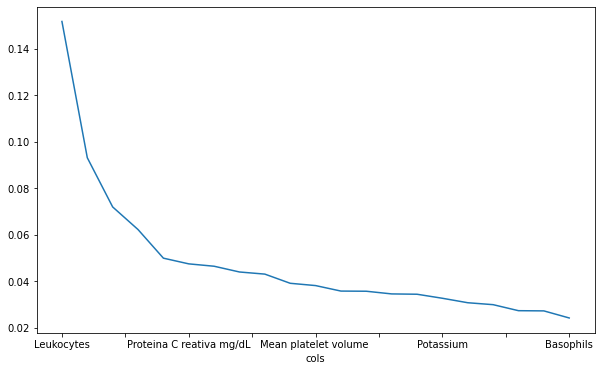

In [209]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [272]:
m = ExtraTreesClassifier(n_jobs=-1)
m.fit(X_imputed, y)
m.score(X_imputed, y)

1.0

In [273]:
fi = rf_feat_importance(m, X_imputed)

In [274]:
fi

,cols,imp
8,Leukocytes,0.103606
3,Platelets,0.088148
13,Monocytes,0.067679
11,Eosinophils,0.061569
17,Proteina C reativa mg/dL,0.053895
0,Patient age quantile,0.053313
5,Red blood Cells,0.040408
9,Basophils,0.040400
18,Creatinine,0.040350
1,Hematocrit,0.040189


<AxesSubplot:xlabel='cols'>

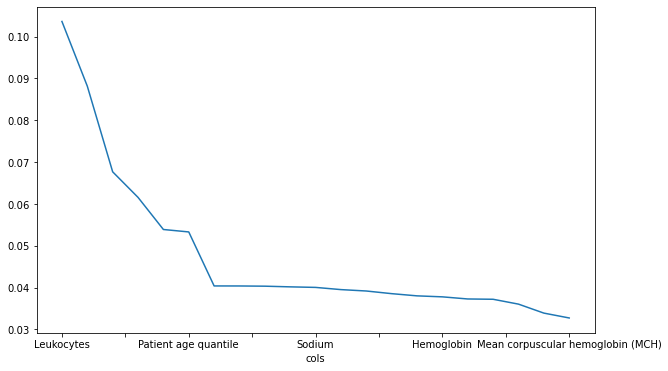

In [275]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [276]:
to_keep = fi[fi.imp>0.04].cols; len(to_keep)

11

In [277]:
df_keep = X_imputed[to_keep]

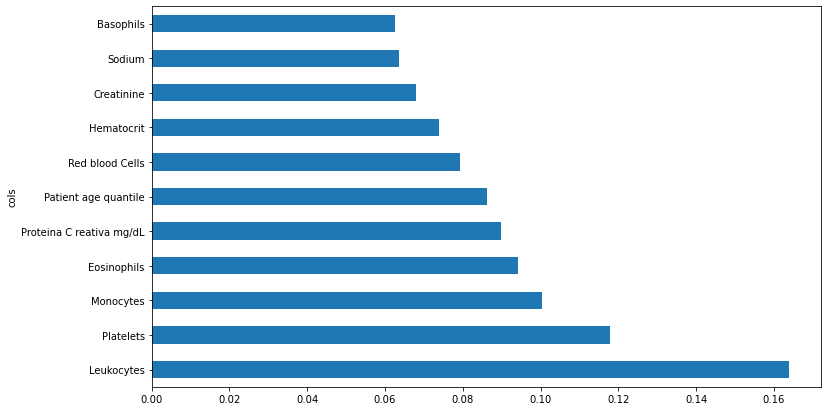

In [278]:
m.fit(df_keep, y)
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [280]:
fi

,cols,imp
0,Leukocytes,0.163986
1,Platelets,0.117811
2,Monocytes,0.100428
3,Eosinophils,0.094107
4,Proteina C reativa mg/dL,0.089948
5,Patient age quantile,0.086169
6,Red blood Cells,0.079386
9,Hematocrit,0.073888
8,Creatinine,0.067894
10,Sodium,0.063709


# Plot

In [257]:
main = ['Leukocytes', 'Platelets', 'Eosinophils', 'Monocytes', 'Proteina C reativa mg/dL']

In [300]:
visual = X_imputed[main].copy()

In [303]:
visual.rename(columns={'Proteina C reativa mg/dL':'CRP'}, inplace=True)

In [301]:
visual['SARSCov'] = y.values

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

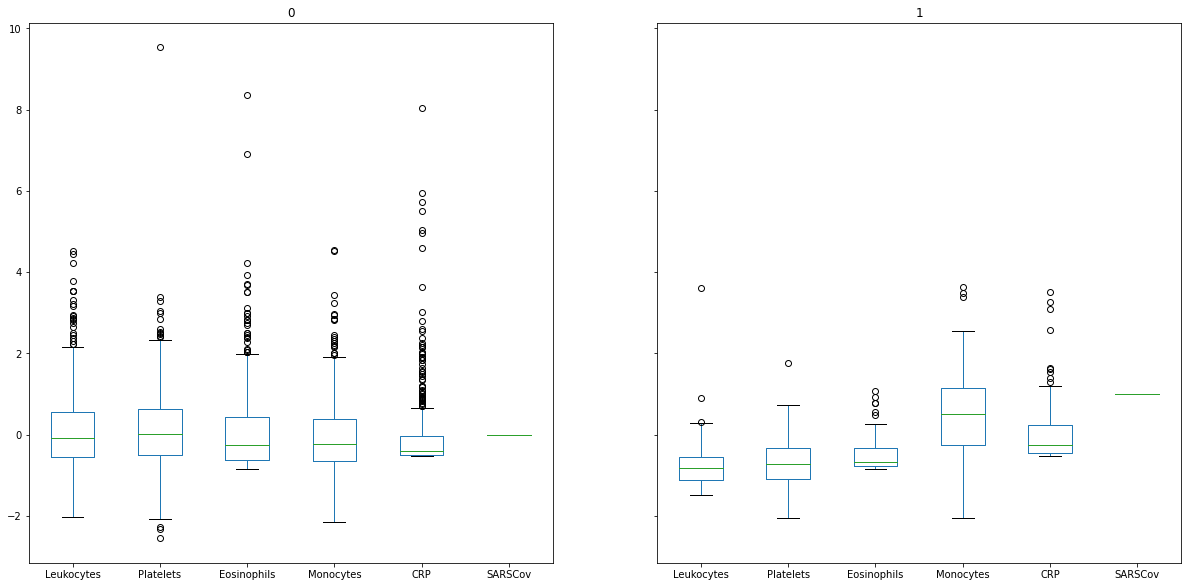

In [304]:
visual.groupby("SARSCov").boxplot(figsize=(20,10), grid=False)

In [238]:
y.value_counts()

0    520
1     83
Name: SARSCov, dtype: int64

In [14]:
# %load ERLX.py
#!/usr/bin/python

import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

# load dataset
covid_df   = pd.read_csv("covid_data.csv")
covid_cols = ["SARSCov", "Hemoglobin", "Platelets", "Leukocytes",
                     "Lymphocytes", "Basophils", "Eosinophils", "Neutrophils",
                     "Monocytes", "Patient age quantile", "Urea", "Proteina C reativa mg/dL",
                     "Creatinine", "Potassium", "Sodium", "Alanine transaminase",
                     "Aspartate transaminase", "International normalized ratio (INR)",
                     "Albumin"]

covid_df = covid_df[covid_cols]

models = [
    ExtraTreesClassifier(n_estimators=300, max_depth=17),
    RandomForestClassifier(n_estimators=300, max_depth=17),
    LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
                        class_weight='balanced')
]

# configure bootstrap
n_iterations = 1

accuracies_stats  = list()
AUC_stats         = list()
pre_stats         = list()
recall_stats      = list()
f1_stats          = list()
sensitivity_stats = list()
specificity_stats = list()
TP_list = list()
TN_list = list()
FP_list = list()
FN_list = list()

for i in range(n_iterations):

    imputer = KNNImputer(n_neighbors=7)
    Ximputer = imputer.fit_transform(covid_df)
    dataframe=pd.DataFrame(Ximputer, columns=covid_cols)

    outlier_detect = IsolationForest(n_estimators=150, max_samples=621, contamination=float(0.07), max_features=covid_df.shape[1])

    outlier_detect.fit(dataframe)
    outliers_predicted = outlier_detect.predict(dataframe)

    covid_check = dataframe[outlier_detect.predict(dataframe) == -1]

    dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

    values = dataframe.values

    n_size = int(len(dataframe) * 0.80)
	# prepare train and test sets
    data_sample = resample(values, n_samples=n_size)

    dataframe = pd.DataFrame(data_sample, columns=covid_cols)
    # split into input and output elements
    y = dataframe.SARSCov # Target variable
    X = dataframe.drop(['SARSCov'], axis = 1) # Features

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    sm = SMOTE(k_neighbors=11)
    x_res, y_res = sm.fit_sample(X_train, y_train)

    S_train, S_test = stacking(models,
                               x_res, y_res, X_test,
                               regression=False,

                               mode='oof_pred',

                               needs_proba=False,

                               save_dir=None,

                               metric=metrics.accuracy_score,

                               n_folds=10,

                               stratified=True,

                               shuffle=True,

                               verbose=2)

    model = XGBClassifier(learning_rate=1.0,
                          n_estimators=300, max_depth=17)

    # fit model
    model = model.fit(S_train, y_res)

	# evaluate model
    y_pred = model.predict(S_test)
    score = metrics.accuracy_score(y_test, y_pred)

    accuracies_stats.append(score)

    probs = model.predict_proba(S_test)
    probs = probs[:, 1]
    AUC_stats.append(metrics.roc_auc_score(y_test, probs))

    pre_stats.append(metrics.precision_score(y_test, y_pred, average='binary'))
    recall_stats.append(metrics.recall_score(y_test, y_pred, average='binary'))
    f1_stats.append(metrics.f1_score(y_test, y_pred, average='binary'))

    confusion = metrics.confusion_matrix(y_test, y_pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # recall of the positive
    sensitivity = TP / float(FN + TP)

    # recall of the negative class
    specificity = TN / (TN + FP)

    sensitivity_stats.append(sensitivity)
    specificity_stats.append(specificity)

    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)

print("Average TP  = {}".format(np.round(np.array(TP_list).mean(), 4)))
print("Average TN  = {}".format(np.round(np.array(TN_list).mean(), 4)))
print("Average FP  = {}".format(np.round(np.array(FP_list).mean(), 4)))
print("Average FN  = {}".format(np.round(np.array(FN_list).mean(), 4)))

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(accuracies_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(accuracies_stats, p))

print("Average accuracy  = {}".format(np.round(np.array(accuracies_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(AUC_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(AUC_stats, p))

print("Average AUC       = {}".format(np.round(np.array(AUC_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(pre_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(pre_stats, p))
print("Average precision = {}".format(np.round(np.array(pre_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(recall_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(recall_stats, p))
print("Average recall    = {}".format(np.round(np.array(recall_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(f1_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(f1_stats, p))
print("Average f1 score = {}".format(np.round(np.array(f1_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(sensitivity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(sensitivity_stats, p))
print("Sensitivity score = {}".format(np.round(np.array(sensitivity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(specificity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(specificity_stats, p))
print("Specificity score = {}".format(np.round(np.array(specificity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred]
n_models:     [3]

model  0:     [ExtraTreesClassifier]
    fold  0:  [1.00000000]
    fold  1:  [1.00000000]
    fold  2:  [1.00000000]
    fold  3:  [1.00000000]
    fold  4:  [1.00000000]
    fold  5:  [1.00000000]
    fold  6:  [0.99838969]
    fold  7:  [1.00000000]
    fold  8:  [1.00000000]
    fold  9:  [0.99838710]
    ----
    MEAN:     [0.99967768] + [0.00064464]
    FULL:     [0.99967784]

    Fitting on full train set...

model  1:     [RandomForestClassifier]
    fold  0:  [1.00000000]
    fold  1:  [0.99838969]
    fold  2:  [1.00000000]
    fold  3:  [1.00000000]
    fold  4:  [1.00000000]
    fold  5:  [1.00000000]
    fold  6:  [0.99838969]
    fold  7:  [1.00000000]
    fold  8:  [1.00000000]
    fold  9:  [1.00000000]
    ----
    MEAN:     [0.99967794] + [0.00064412]
    FULL:     [0.99967784]

    Fitting on full train set...

model  2:     [LogisticRegression]

In [1]:
# 
#!/usr/bin/python



# load dataset


models = [
    ExtraTreesClassifier(n_estimators=300, max_depth=17),
    RandomForestClassifier(n_estimators=300, max_depth=17),
    LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
                        class_weight='balanced')
]

# configure bootstrap
n_iterations = 1

accuracies_stats  = list()
AUC_stats         = list()
pre_stats         = list()
recall_stats      = list()
f1_stats          = list()
sensitivity_stats = list()
specificity_stats = list()
TP_list = list()
TN_list = list()
FP_list = list()
FN_list = list()

for i in range(n_iterations):

    imputer = KNNImputer(n_neighbors=7)
    Ximputer = imputer.fit_transform(covid_df)
    dataframe=pd.DataFrame(Ximputer, columns=covid_cols)

    outlier_detect = IsolationForest(n_estimators=150, max_samples=621, contamination=float(0.07), max_features=covid_df.shape[1])

    outlier_detect.fit(dataframe)
    outliers_predicted = outlier_detect.predict(dataframe)

    covid_check = dataframe[outlier_detect.predict(dataframe) == -1]

    dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

    values = dataframe.values

    n_size = int(len(dataframe) * 0.80)
	# prepare train and test sets
    data_sample = resample(values, n_samples=n_size)

    dataframe = pd.DataFrame(data_sample, columns=covid_cols)
    # split into input and output elements
    y = dataframe.SARSCov # Target variable
    X = dataframe.drop(['SARSCov'], axis = 1) # Features

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    sm = SMOTE(k_neighbors=11)
    x_res, y_res = sm.fit_sample(X_train, y_train)

    S_train, S_test = stacking(models,
                               x_res, y_res, X_test,
                               regression=False,

                               mode='oof_pred',

                               needs_proba=False,

                               save_dir=None,

                               metric=metrics.accuracy_score,

                               n_folds=10,

                               stratified=True,

                               shuffle=True,

                               verbose=2)

    model = XGBClassifier(learning_rate=1.0,
                          n_estimators=300, max_depth=17)

    # fit model
    model = model.fit(S_train, y_res)

	# evaluate model
    y_pred = model.predict(S_test)
    score = metrics.accuracy_score(y_test, y_pred)

    accuracies_stats.append(score)

    probs = model.predict_proba(S_test)
    probs = probs[:, 1]
    AUC_stats.append(metrics.roc_auc_score(y_test, probs))

    pre_stats.append(metrics.precision_score(y_test, y_pred, average='binary'))
    recall_stats.append(metrics.recall_score(y_test, y_pred, average='binary'))
    f1_stats.append(metrics.f1_score(y_test, y_pred, average='binary'))

    confusion = metrics.confusion_matrix(y_test, y_pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # recall of the positive
    sensitivity = TP / float(FN + TP)

    # recall of the negative class
    specificity = TN / (TN + FP)

    sensitivity_stats.append(sensitivity)
    specificity_stats.append(specificity)

    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)

print("Average TP  = {}".format(np.round(np.array(TP_list).mean(), 4)))
print("Average TN  = {}".format(np.round(np.array(TN_list).mean(), 4)))
print("Average FP  = {}".format(np.round(np.array(FP_list).mean(), 4)))
print("Average FN  = {}".format(np.round(np.array(FN_list).mean(), 4)))

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(accuracies_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(accuracies_stats, p))

print("Average accuracy  = {}".format(np.round(np.array(accuracies_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(AUC_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(AUC_stats, p))

print("Average AUC       = {}".format(np.round(np.array(AUC_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(pre_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(pre_stats, p))
print("Average precision = {}".format(np.round(np.array(pre_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(recall_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(recall_stats, p))
print("Average recall    = {}".format(np.round(np.array(recall_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(f1_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(f1_stats, p))
print("Average f1 score = {}".format(np.round(np.array(f1_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(sensitivity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(sensitivity_stats, p))
print("Sensitivity score = {}".format(np.round(np.array(sensitivity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(specificity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(specificity_stats, p))
print("Specificity score = {}".format(np.round(np.array(specificity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
